# Open and run analysis on multiple polygons
* **Compatability:** Notebook currently compatible with the `NCI`|`DEA Sandbox` environments
* **Products used:** 
[`ga_ls5t_ard_3`](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[`ga_ls7e_ard_3`](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[`ga_ls8c_ard_3`](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)

### Background
Many users need to run analyses on their own areas of interest. A common use case involves running the same analysis across multiple polygons in a shapefile.

### Description
If we have a vector file containing multiple polygons, we can use the python package [geopandas](https://geopandas.org/) to open it and iterate through the files. 
We can retrieve data for each polygon, perform an analysis like calculating NDVI and plot the data.
1. First we open the polygon using the [geopandas](https://geopandas.org/) package
2. Then we retrieve data from DEA
3. Then we calculate NDVI as an example analysis
4. Then we plot NDVI for the polygon


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Please note the use of `datacube utilities` package `geometry`: 
this is important for saving the coordinate reference system of the incoming shapefile in a format that the Digital Earth Australia query can understand. 
It has the same name as the `shapely.geometry` package, and should be imported later as in the cell below.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import geopandas as gpd
from copy import deepcopy
from datacube.utils import geometry

import sys
sys.path.append('../Scripts')
from dea_datahandling import load_ard
from dea_bandindices import calculate_indices
from dea_plotting import rgb, map_shapefile
from dea_temporaltools import time_buffer
from dea_spatialtools import xr_rasterize

### Connect to the datacube
Give your datacube app a unique name. 
Ideally, this will be the same as the notebook file name.

In [2]:
dc = datacube.Datacube(app='Analyse_multiple_polygons')

## Analysis Parameters

In [3]:
time_of_interest = '2019-02-01'
time_buff = '30 days'

shapefile = '../Supplementary_data/Analyse_multiple_polygons/multiple_polys.shp'
attribute_col = 'id'

products = ['ga_ls8c_ard_3']
measurements =  ['nbart_red','nbart_green','nbart_blue','nbart_nir']
resolution = (-25, 25)
align = (15, 15)

### Look at the structure of the vector file
Import the file and take a look at how the file is structured so we understand what we are iterating through. 
There are two polygons in the file.

We then plot the shapefile using the function `map_shapefile`

In [4]:
gdf = gpd.read_file(shapefile)
gdf.head()

,id,geometry
0,2,"POLYGON ((980959.746 -3560845.144, 983880.024 ..."
1,1,"POLYGON ((974705.494 -3565359.492, 977625.771 ..."


In [5]:
map_shapefile(gdf, attribute=attribute_col)

Label(value='')

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/…

### Create a datacube query object

In [6]:
query = {'time': (time_buffer(time_of_interest, buffer=time_buff)),
         'measurements': measurements,
         'resolution': resolution
         }


## Loading satellite data

Here we will iterate through each row of the geopandas dataframe and load satellite data.  The results will be appended to a dictionary object which we can later inex to analyse each dataset.

In [7]:
# dictionary to save results 
results = {}

# a progress indicator
i = 0

# loop through polygons in geodataframe and extract satellite data
for index, row in gdf.iterrows():
    print("Feature: " + str(i + 1) + "/" +str(len(gdf)))
    
    # prevent function altering dict kwargs
    dc_query = deepcopy(query)
    
    #get the geometry
    geom = geometry.Geometry(
        gdf.geometry.values[index].__geo_interface__, geometry.CRS(
            f'EPSG:{gdf.crs.to_epsg()}'))
    
    # update dc query with geometry      
    dc_query.update({"geopolygon": geom}) 
    
    #load landsat
    ds = load_ard(dc=dc, 
                  products=products,
                  #min_gooddata=0.99, #only take uncloudy scenes
                  ls7_slc_off = False,     
                  output_crs='EPSG:3577',
                  align=align,
                  group_by='solar_day',
                  **dc_query)

    # generate a polygon mask to keep data only within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], ds)
    
    # mask dataset
    ds = ds.where(mask)
    
    #append results to a dictionary using the attribute
    #column as an key
    results.update({str(gdf[attribute_col][index]) : ds})
    
    #update counter
    i += 1

Feature: 1/2
Loading ga_ls8c_ard_3 data
    Applying pixel quality/cloud mask
    Applying invalid data mask
Combining and sorting data
    Returning 3 observations 
Rasterizing to match xarray.DataArray dimensions (110, 126) and projection system/CRS (e.g. EPSG:3577)
Feature: 2/2
Loading ga_ls8c_ard_3 data
    Applying pixel quality/cloud mask
    Applying invalid data mask
Combining and sorting data
    Returning 3 observations 
Rasterizing to match xarray.DataArray dimensions (111, 126) and projection system/CRS (e.g. EPSG:3577)


---
## Further analysis

Our `results` dictionary will contain xarray objects labelled by the unique `attribute column` values we specified in the `Analysis Parameters` section. Enter one of those values below to index our dictionary and conduct further analsyis on the satellite timeseries for that polygon 

In [8]:
key = '1'

### Calculate NDVI and plot

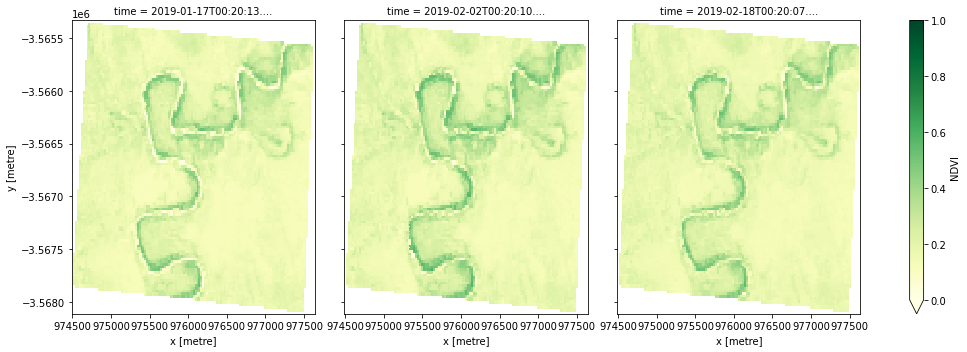

In [9]:
ndvi = calculate_indices(results[key], index='NDVI', collection='ga_ls_3')
        
#plot NDVI for each polygon for the time query
ndvi.NDVI.plot(col='time', cmap='YlGn', vmin=0, vmax=1, figsize=(15,5))
plt.show()

---
## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** April 2020

**Compatible `datacube` version:** 

In [10]:
print(datacube.__version__)

1.7+262.g1cf3cea8


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)